# Lab One: CNN Visualization

#### CS8321: Neural Networks and Machine Learning
    
Johnathan Barr - 39854013
<br>
Will Lacey - 45906124

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [15]:
from __future__ import print_function

import imageio

from keras import backend as K
from keras.applications import inception_v3
from keras.preprocessing.image import load_img, save_img, img_to_array

import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import scipy

import random
from random import randint

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Our DeepDream Argument

[<strong>10 Points</strong>] Based on the blog post above, create and argue for one reason you might use DeepDream to analyze a CNN visually. Write out this argument in text for the lab using your own words. Alternatively, you can also argue for a counter argument (that is, why this is only artistic, not useful). 

We believe that DeepDream is a valuable tool for analyzing CNNs visually. The DeepDream algorithm serves as a "sanity check" to help ensure that a CNN is, in fact, performing as intended. In this vein, one is able to use the output of DeepDream to determine whether or not a CNN understands your target class. In the event that the resulting output surprises you, it can be ascertained that further tweaking is needed for the model to function properly. Such is the case found in the blog, <em>Inceptionism: Going Deeper into Neural Networks</em> (https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html), where a particular CNN used to classify dumbbells. In the example, we see that the CNN has "failed to completely distill the essence of a dumbbell [since] no picture of a dumbbell is complete without a muscular weightlifter there to lift them."

However, if a CNN is used for anything aside from image processing and classification, then the visual output of the DeepDream algorithm ends up making little sense. For instance, if you are implementing a CNN for text classification (as seen here: http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/), then the output of DeepDream would essentially be a confusing, useless mess. Thus, in conclusion, the DeepDream algorithm is useful specifically in visualizing target image classes or, of course, making really cool art.

## Selecting ImageNet and Why

[<strong>10 Points</strong>] In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.). Explain the model you chose and why.

We decided to use ImageNet. ImageNet is a massive dataset of over 15 millions labeled, high-resolution images with around 22,000 categories. InceptionV3 implements ImageNet using a subset of the data with 1000 of its categories, each consisting of 1000 different images. In all, there are roughly 1.2 million training images, 50,000 validation images, and 100,000 testing images (https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c).

We selected ImageNet because, as mentioned previously, it has been pretrained on millions of different image examples and has learned some of the many different patterns found in images. While ImageNet has about a thousand different classes it was trained on, we do not care about the labels for DeepDreaming. Instead, we aim to utilize the learned patterns of ImageNet, such as its ability to detect edges, curves, contrasts, and etc., and apply them in our image processing. This way, we can effectively see the intended result of the DeepDream algorithm without having to build and verify our own CNN architecture. 

Let's load the model. We will now build the InceptionV3 network with pre-trained ImageNet weights. This takes a few seconds.

In [2]:
%%time
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

print('Model has been Loaded')

Model has been Loaded
CPU times: user 11.6 s, sys: 351 ms, total: 11.9 s
Wall time: 11.6 s


## The DeepDream Process

[<strong>20 Points</strong>] Manipulate the code from the CNN visualization notebook to implement the DeepDream process. This includes:
- Using L1 gradient normalization for gradient updates
- Adding random shifts/resizing in the process (as described in DeepDream)
- If using code from another source, you must heavily document the code so that I can grade your understanding of the code used. 

In this section, <strong>The DeepDream Process</strong>, the featured code is actually modified from Francois Chollet's Github. Feel free to check it out here: https://github.com/keras-team/keras/blob/master/examples/deep_dream.py

Now, before we begin DeepDreaming, we are first going to declare a few helper functions that will aid us in image processing. 

In [3]:
def preprocess_image(image_path):
    """
    Image processing function to open, resize, and format pictures 
        into appropriate tensors
    """
    img = load_img(image_path)
    x = img_to_array(img)
    x = np.expand_dims(img, axis=0)
    x = inception_v3.preprocess_input(x)
    return x

def deprocess_image(x):
    """
    Image processing function to convert a tensor into a valid image
    """
    img = x.reshape((x.shape[1], x.shape[2], 3))
    img /= 2.
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def resize_img(img, size):
    """
    Image processing function to resize an image; this induces noise into
        the DeepDreaming process
    """
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

Next, we are going to declare a few more functions that will be part of the DeepDreaming loop. These functions will handle the loss and gradients.

In [4]:
def define_loss(layer_dict):
    """
    Declares and returns the loss for DeepDream
    """
    loss = K.variable(0.)
    for layer_name in settings['features']:
        # Add the L1 norm of the features of a layer to the loss.
        if layer_name not in layer_dict:
            raise ValueError('Layer ' + layer_name + ' not found in model.')
        coeff = settings['features'][layer_name]
        x = layer_dict[layer_name].output
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = K.prod(K.cast(K.shape(x), 'float32'))
        # L1 norm actually applied here
        loss = loss + coeff * K.sum(K.abs(x[:, 2: -2, 2: -2, :])) / scaling
        return loss

def eval_loss_and_grads(x):
    """
    Uses are global variable fetch_loss_and_grads to retrieve the loss and 
        gradients given an input image
    """
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(img, iterations, step, max_loss=None):
    """
    Performs gradient ascent on an image for a number of iterations; this function 
        tries to increase the loss by performing small gradient updates for a 
        given image; returns a list of images from each update
    """
    images_per_update = []
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(img)
        if max_loss is not None and loss_value > max_loss:
            break
        # every 10th iteration, output loss value
        if i % 10 == 0: 
            print('..Loss value at', i, ':', loss_value)
        img += step * grad_values
        # save each gradient update to images_per_update
        images_per_update.append(np.copy(img))
    return images_per_update

Lastly, we are going to write the methods that will make up the core DeepDream algorithm. Using the functions before, the following code can be called to run DeepDream on an image.

In [5]:
def setup_deepdream():
    """
    Prepares for execute_deepdream(); gets loss and gradients for DeepDream and creates
        a variable fetch_loss_and_grads that must be made into a global variable for 
        the algorithm to run
    """
    # Sets the learning phase to 0
    K.set_learning_phase(0)
    # Set 'dream' to our model placeholder
    dream = model.input
    # Get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    # Define the loss.
    loss = define_loss(layer_dict)
    # Compute the gradients of the dream with respect to the loss.
    grads = K.gradients(loss, dream)[0]
    # Normalize gradients. Epsilon is included to avoid dividing by zero.
    grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    # Set up function to retrieve the value
    # of the loss and gradients given an input image.
    outputs = [loss, grads]
    fetch_loss_and_grads = K.function([dream], outputs)
    return fetch_loss_and_grads

def execute_deepdream(image_path, step=0.01, num_octave=3, octave_scale=1.4, 
              iterations=20, max_loss=10, custom_noise=False):
    """
    Params: (playing with these hyperparameters will also allow you to achieve new effects)
        - image_path: path to input image
        - step: Gradient ascent step size
        - num_octave: Number of scales at which to run gradient ascent
        - octave_scale: Size ratio between scales
        - iterations: Number of ascent steps per scale
        - max_loss: max loss for gradient ascent
        - custom_noise: adds gaussian to image
    
    Process:
        - Load the original image.
        - Define a number of processing scales (i.e. image shapes),
            from smallest to largest.
        - Resize the original image to the smallest scale.
        - For every scale, starting with the smallest (i.e. current one):
            - Run gradient ascent
            - Upscale image to the next scale
            - Reinject the detail that was lost at upscaling time
        - Stop when we are back to the original size.

        To obtain the detail lost during upscaling, we simply
        take the original image, shrink it down, upscale it,
        and compare the result to the (resized) original image.
    """
    
    img = preprocess_image(image_path)
    images_per_update = []
    
    # if we are not adding noise, the process will involve shifting and resizing
    # and thus has more logic
    if not custom_noise:
        original_shape = img.shape[1:3]
        successive_shapes = [original_shape]
        for i in range(1, num_octave):
            # declare the shape sizes for each octave
            shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
            successive_shapes.append(shape)
            successive_shapes = successive_shapes[::-1]
            original_img = np.copy(img)
            
            # shrink image for inducing noise during DeepDream
            shrunk_original_img = resize_img(img, successive_shapes[0])

        for shape in successive_shapes:
            print('Processing image shape', shape)
            img = resize_img(img, shape)

            # execute gradient ascent at a given shape size
            imgs_per_up = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
            # update the image placeholder for next gradient ascent
            img = imgs_per_up[-1]

            # add back the lost detail from resizing into the DeepDream image
            upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
            same_size_original = resize_img(original_img, shape)
            lost_detail = same_size_original - upscaled_shrunk_original_img
            # Add lost detail to image placeholder
            img += lost_detail
            
            # Additionally, for every image from the gradient ascent...
            for i in range(len(imgs_per_up)):
                # add lost detail to image
                imgs_per_up[i] += lost_detail
                # add new image to images_per_update
                imgs_per_up[i] = deprocess_image(np.copy(imgs_per_up[i]))

            # add each image from the gradient ascent to images_per_update
            images_per_update += imgs_per_up
                
            # shrink original image for next shape
            shrunk_original_img = resize_img(original_img, shape)
            
    # otherwise, our custom noise takes the place of the shifting and resizing,
    # thus less logic will be needed here
    else:
        for _ in range(num_octave):
            # execute gradient ascent at a given shape size
            imgs_per_up = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
            # update the image placeholder for next gradient ascent
            img = imgs_per_up[-1]
            # Noisify our image placeholder
            img = noisify(img)
            print("Injecting custom noise")
            
            # Additionally, for every image from the gradient ascent...
            for i in range(len(imgs_per_up)):
                # add new image to images_per_update
                imgs_per_up[i] = deprocess_image(np.copy(imgs_per_up[i])) 
                
            # add each image from the gradient ascent to images_per_update
            images_per_update += imgs_per_up
        
    # Return output image and each gradient update image
    return images_per_update

Cool! Everything is ready. Now all that we need to do is simply run the program. In the next cell, we execute the DeepDream algorithm on an image; running it for a few hundered iterations. This takes a couple minutes.

In [6]:
# paths of input and output images
input_image_path = 'data/landscape.jpg'
output_image_path1 = 'data/dreaming1.png'
output_image_path2 = 'data/dreaming2.png'

    
# These are the names of the layers for which we try to maximize activation,
    # as well as their weight in the final loss we try to maximize.
    # You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

# This prepares for the next function 'execute_deepdream'; it gets the loss 
    # and gradients needed to run the algorithm
fetch_loss_and_grads = setup_deepdream()

# Runs DeepDream
images_per_update1 = execute_deepdream(input_image_path, 
                                       step=0.01,
                                       num_octave=3,
                                       octave_scale=1.1,
                                       iterations=100, 
                                       max_loss=50)

# Grab the output from the last update
output_image1 = images_per_update1[-1]

# save the output image
save_img(output_image_path1, output_image1)

Processing image shape (401, 612)
..Loss value at 0 : 0.049091853
..Loss value at 10 : 0.10504136
..Loss value at 20 : 0.12758967
..Loss value at 30 : 0.14206402
..Loss value at 40 : 0.15310691
..Loss value at 50 : 0.16262701
..Loss value at 60 : 0.17121309
..Loss value at 70 : 0.17936037
..Loss value at 80 : 0.18757612
..Loss value at 90 : 0.19623825
Processing image shape (486, 741)
..Loss value at 0 : 0.088121
..Loss value at 10 : 0.15280198
..Loss value at 20 : 0.17660594
..Loss value at 30 : 0.19486475
..Loss value at 40 : 0.21182907
..Loss value at 50 : 0.2284436
..Loss value at 60 : 0.24560857
..Loss value at 70 : 0.26354757
..Loss value at 80 : 0.2825797
..Loss value at 90 : 0.3030669
Processing image shape (441, 673)
..Loss value at 0 : 0.12519665
..Loss value at 10 : 0.21694854
..Loss value at 20 : 0.26201522
..Loss value at 30 : 0.29882213
..Loss value at 40 : 0.33298063
..Loss value at 50 : 0.36662465
..Loss value at 60 : 0.400363
..Loss value at 70 : 0.4345607
..Loss value

## Visualizing DeepDream

[<strong>20 Points</strong>] Choose an image to seed the DeepDream visualizations and run the DeepDream process. Save out the image at various steps so that you can visualize the iterative process (a video or GIF would be a nice addition). Explain any clues that the iterative process gives for how the CNN discerns different classes, if any. 

Before we visualize the DeepDream process, here is the original image we ran DeepDream on. The following cell serves as a useful reference to what the original image looked like before executing the DeepDream algorithm.

Image Tensor size: (1, 486, 741, 3)


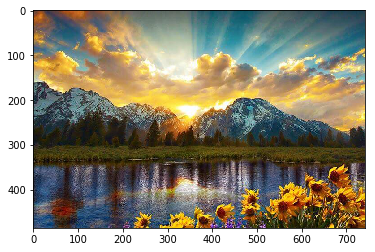

In [7]:
image_tensor = preprocess_image(input_image_path)
print('Image Tensor size: ' + str(image_tensor.shape))

original_image = deprocess_image(image_tensor)
plt.imshow(original_image)
plt.show()

We chose this image because it consists of a variety of low and high frequency textures along with a few different pieces of scenery. This will allow us to evaluate how the algorithm functions on different areas or types of images.
<br><br>
Okay, let's visualize some images after DeepDreaming.

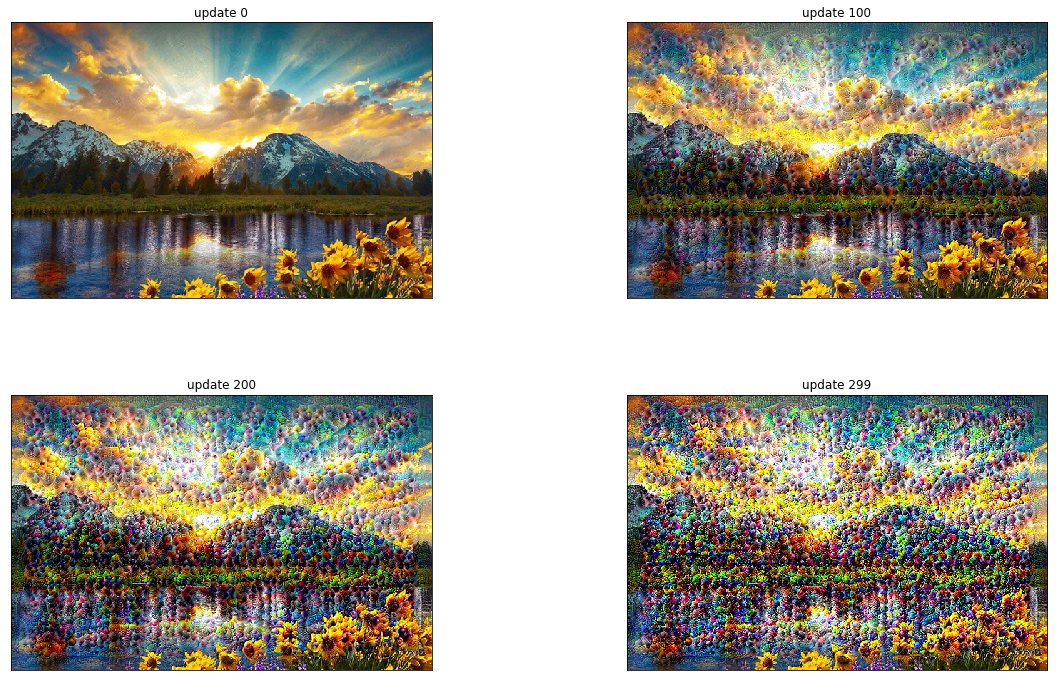

In [8]:
def plot_progression_gallery(img_set):
    plt.figure(figsize=(16, 10))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    indices = [0, int(len(img_set)/3), int(2*len(img_set)/3), len(img_set)-1]
    for i in range(4):
        index = indices[i]
        plt.subplot(2, 2, i + 1)
        plt.imshow(img_set[index])
        plt.title('update ' + str(index), size=12)
        plt.xticks(())
        plt.yticks(())


plot_progression_gallery(images_per_update1)

In this next cell, we create and save a gif of each image made in every iteration of gradient ascent.

In [9]:
gif_name1 = 'data/movie1.gif'
imageio.mimsave(gif_name1, images_per_update1)

![gif](data/movie1.gif "gif")

In this animation, we can oberve patterns start emerge in differently in different areas of the image. And certain patterns grow faster than others. This hints at the CNN detecting different classes in these different areas. And the iterative approach allows for the "dreaming" process to focus on these different areas for their respective classes once one is "settled upon" under the hood.

## Visualizing DeepDream with Noise

[<strong>10 Points</strong>] Exceptional work: hypothesize another type of noise to introduce in the DeepDream process and implement it. Run the same image through as before and compare/contrast the result. 

Based on code found here: https://stackoverflow.com/a/30609854, we created a gaussian noise injection function that can be added to an image.

In [10]:
def noisify(image):
    row,col,ch = image.shape[1:4]
    mean = 0
    var = 0.1
    multiplier = 0.75
    sigma = var**multiplier
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

By setting the parameter <strong>is_adding_noise</strong> to <strong>True</strong> within our <strong>execute_deepdream</strong> function, we are able to call our <strong>noisy</strong> function during the process of DeepDreaming.

In [11]:
images_per_update2 = execute_deepdream(input_image_path, 
                                               step=0.01,
                                               num_octave=3,
                                               octave_scale=1.1,
                                               iterations=100, 
                                               max_loss=50, 
                                               custom_noise=True)

# Grab the output from the last update
output_image2 = images_per_update2[-1]

save_img(output_image_path2, output_image2)

..Loss value at 0 : 0.04985574
..Loss value at 10 : 0.10601701
..Loss value at 20 : 0.12972932
..Loss value at 30 : 0.14516655
..Loss value at 40 : 0.15730567
..Loss value at 50 : 0.16763206
..Loss value at 60 : 0.1772922
..Loss value at 70 : 0.18656932
..Loss value at 80 : 0.19583924
..Loss value at 90 : 0.20542824
Injecting custom noise
..Loss value at 0 : 0.1533453
..Loss value at 10 : 0.22190234
..Loss value at 20 : 0.2414777
..Loss value at 30 : 0.25914052
..Loss value at 40 : 0.27718967
..Loss value at 50 : 0.29626358
..Loss value at 60 : 0.31616822
..Loss value at 70 : 0.33713007
..Loss value at 80 : 0.35929364
..Loss value at 90 : 0.38275567
Injecting custom noise
..Loss value at 0 : 0.33784428
..Loss value at 10 : 0.4277906
..Loss value at 20 : 0.46213415
..Loss value at 30 : 0.49395105
..Loss value at 40 : 0.5255202
..Loss value at 50 : 0.5573709
..Loss value at 60 : 0.590021
..Loss value at 70 : 0.62367207
..Loss value at 80 : 0.65786374
..Loss value at 90 : 0.6932336
Inject

Repeating the visualizations from above, we have the following output:

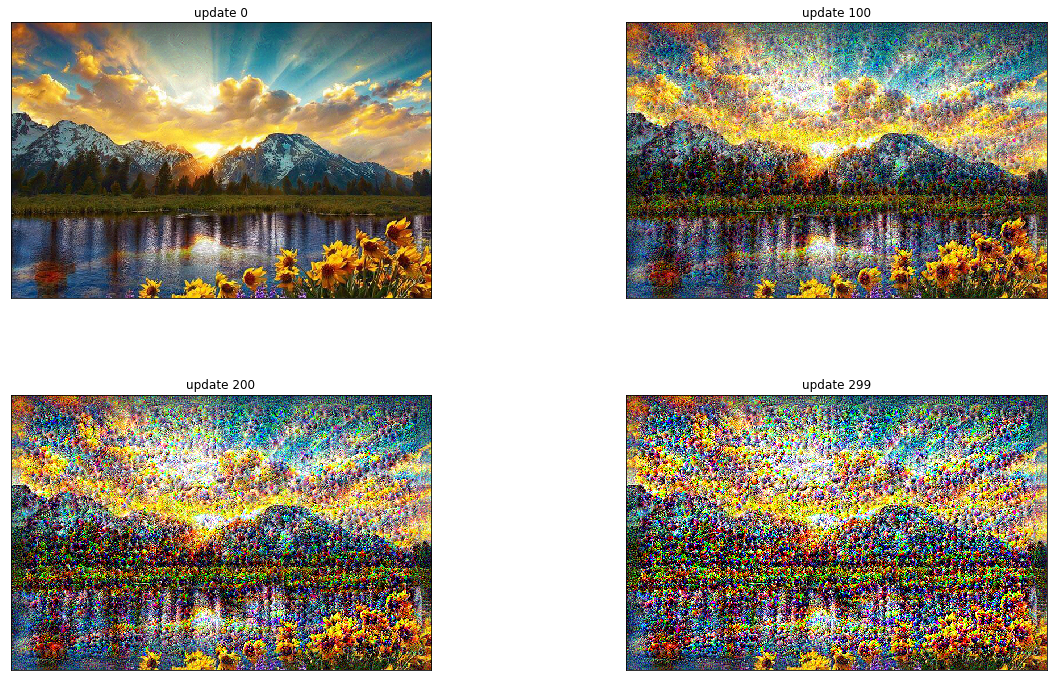

In [12]:
plot_progression_gallery(images_per_update2)

In [13]:
gif_name2 = 'data/movie2.gif'
imageio.mimsave(gif_name2, images_per_update2)

![gif](data/movie2.gif "gif")

## Comparison of Results

([], <a list of 0 Text yticklabel objects>)

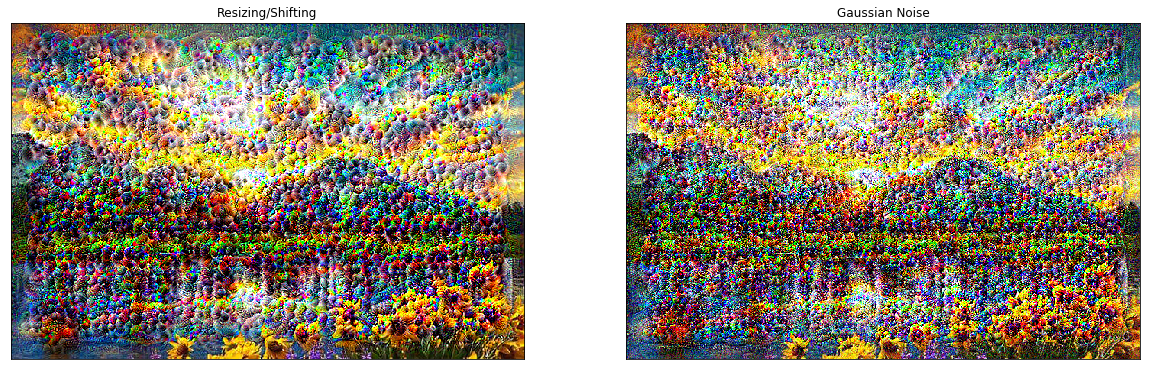

In [14]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
plt.subplot(1, 2, 1)
image_tensor1 = preprocess_image(output_image_path1)
image1 = deprocess_image(image_tensor1)
plt.imshow(image1)
plt.title('Resizing/Shifting', size=12)

plt.xticks(())
plt.yticks(())

plt.subplot(1, 2, 2)
image_tensor2 = preprocess_image(output_image_path2)
image2 = deprocess_image(image_tensor2)
plt.imshow(image2)
plt.title('Gaussian Noise', size=12)
plt.xticks(())
plt.yticks(())

While the outputted images from each noise method are similar, they are distinct. The reshifting/resizing has a higher contrast than the Gaussian noise. The "dream circles" have sharper edges. Whereas the Gaussian noise output is slightly more tame but fuzzy from the noise being inserted. However, the fact that both are so similar implies that the effect is primarily derived from the gradient ascent as opposed to the noise method of choice. See actual image files for higher resolution versions for comparison.